In [ ]:
!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
import findspark
findspark.init()

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd '/content/gdrive/MyDrive/LDS9_K265_TranHoangBach/Week_3/data_day_6'

Mounted at /content/gdrive
/content/gdrive/MyDrive/LDS9_K265_TranHoangBach/Week_3/data_day_6


In [ ]:
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder, OneHotEncoderEstimator
from pyspark.ml.feature import MinMaxScaler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [ ]:
sc = SparkContext(master="local", appName="New Spark Context")
spark = SparkSession(sc)

In [ ]:
df = spark.read.csv("dog_food.csv", header=True, inferSchema=True)
df.show(5)

+---+---+----+---+-------+
|  A|  B|   C|  D|Spoiled|
+---+---+----+---+-------+
|  4|  2|12.0|  3|    1.0|
|  5|  6|12.0|  7|    1.0|
|  6|  2|13.0|  6|    1.0|
|  4|  2|12.0|  1|    1.0|
|  4|  2|12.0|  3|    1.0|
+---+---+----+---+-------+
only showing top 5 rows



In [ ]:
df.count()

490

In [ ]:
df.printSchema()

root
 |-- A: integer (nullable = true)
 |-- B: integer (nullable = true)
 |-- C: double (nullable = true)
 |-- D: integer (nullable = true)
 |-- Spoiled: double (nullable = true)



In [ ]:
df.groupby('Spoiled').count().show()

+-------+-----+
|Spoiled|count|
+-------+-----+
|    0.0|  350|
|    1.0|  140|
+-------+-----+



In [ ]:
df = df.withColumnRenamed('Spoiled', 'label')

In [ ]:
input_cols = df.columns[:-1]
assembler = VectorAssembler(inputCols=input_cols, outputCol='features_not_scale')
scaler = MinMaxScaler(inputCol="features_not_scale", outputCol="features")

pipeline_preprocessing = Pipeline(stages=[assembler, scaler])
pipe_preprocessing = pipeline_preprocessing.fit(df)
final_df = pipe_preprocessing.transform(df)
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LogisticRegression

list_model = [('Logistic Regression', LogisticRegression()),
              ('Decision Tree', DecisionTreeClassifier()), 
              ('Random Forest', RandomForestClassifier()), 
              ('Gradient Boosting', GBTClassifier()),
]

for model_name, model in list_model:
    trained_model = model.fit(train_df)
    predictions = trained_model.transform(test_df)
    predictions = predictions.withColumn('label', predictions.label.cast(DoubleType()))

    prediction_and_label = predictions.select(['prediction', 'label'])
    metrics = MulticlassMetrics(prediction_and_label.rdd)
    evaluator = BinaryClassificationEvaluator()
    print('-'*30)
    print(model_name)
    print('  Accuracy \t\t: {:.4f}'.format(metrics.accuracy))
    print('  Precisions (label=1)\t: {:.4f}'.format(metrics.precision(label=1)))
    print('  Recall (label=1)\t: {:.4f}'.format(metrics.recall(label=1)))
    print('  f1_score (label=1)\t: {:.4f}'.format(metrics.fMeasure(label=1.0)))
    print('  AUC \t\t\t: {:.4f}'.format(evaluator.evaluate(predictions)))
    result_confusion_matrix = pd.DataFrame(metrics.confusionMatrix().toArray(), columns=['Predict Neg', 'Predict Pos'], index=['Actual Neg', 'Actual Pos'])
    display(result_confusion_matrix)

------------------------------
Logistic Regression
  Accuracy 		: 1.0000
  Precisions (label=1)	: 1.0000
  Recall (label=1)	: 1.0000
  f1_score (label=1)	: 1.0000
  AUC 			: 1.0000


,Predict Neg,Predict Pos
Actual Neg,65.0,0.0
Actual Pos,0.0,26.0


------------------------------
Decision Tree
  Accuracy 		: 0.9890
  Precisions (label=1)	: 1.0000
  Recall (label=1)	: 0.9615
  f1_score (label=1)	: 0.9804
  AUC 			: 0.9615


,Predict Neg,Predict Pos
Actual Neg,65.0,0.0
Actual Pos,1.0,25.0


------------------------------
Random Forest
  Accuracy 		: 1.0000
  Precisions (label=1)	: 1.0000
  Recall (label=1)	: 1.0000
  f1_score (label=1)	: 1.0000
  AUC 			: 1.0000


,Predict Neg,Predict Pos
Actual Neg,65.0,0.0
Actual Pos,0.0,26.0


------------------------------
Gradient Boosting
  Accuracy 		: 0.9890
  Precisions (label=1)	: 1.0000
  Recall (label=1)	: 0.9615
  f1_score (label=1)	: 0.9804
  AUC 			: 0.9953


,Predict Neg,Predict Pos
Actual Neg,65.0,0.0
Actual Pos,1.0,25.0


In [ ]:
model = RandomForestClassifier()
trained_model = model.fit(final_df)
importance_result = pd.DataFrame(trained_model.featureImportances.toArray(), index=input_cols, columns=['importance_features']).sort_values('importance_features', ascending=False)
importance_result

,importance_features
C,0.940706
D,0.020179
B,0.019787
A,0.019328


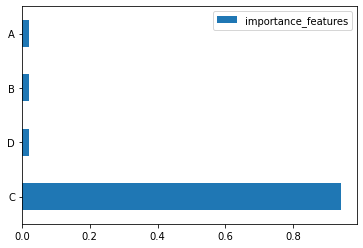

In [ ]:
importance_result.plot.barh();

In [ ]:
# C is most importance feature
# and model Random Forest work perfect when detect 100% accuracy, both on train and test data